In [ ]:
import flopy
from pathlib import Path
import flopy.utils as fu
import os, shutil
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import platform

### clean up from a previous run

In [ ]:
cleanup = True
if cleanup is True:
    rundirs = Path('.')
    olddirs = [i for i in rundirs.glob('ps*') if (os.path.isdir(i)) & ('fgdata' not in i.name)]
    [shutil.rmtree(i) for i in olddirs];

# Look at the initial results from PS1

In [ ]:
# first load in the initial model

In [ ]:
if 'window' in platform.platform().lower():
    mfexe = os.path.abspath('./bin/mf6.exe')
else:
    mfexe = os.path.abspath('./bin/mf6')

In [ ]:
sim = flopy.mf6.MFSimulation.load(sim_ws = './initial/', exe_name=mfexe)

### reset the top to 400 feet

In [ ]:
m = sim.get_model()
m.dis.top = 400

In [ ]:
# run this as-is and look at the head file

In [ ]:
sim.set_sim_path('./ps1')


In [ ]:
sim.write_simulation()

In [ ]:
sim.run_simulation()

In [ ]:
m1head = m.output.head().get_data()

In [ ]:
fig, ax = plt.subplots(3,1)
for i in range(m1head.shape[0]):
    d=ax[i].imshow(m1head[i])
    plt.colorbar(d)
    plt.tight_layout()

# Part A: The Recharge Package

### add rechage to the model and remove the canal (constant head on the left boundary)

In [ ]:
sim.set_sim_path('ps2a')
m = sim.get_model()

In [ ]:
r = flopy.mf6.ModflowGwfrcha(m,recharge=0.005)

In [ ]:
chd_spd = pd.DataFrame.from_records(m.chd.stress_period_data.array[0])
chd_spd

In [ ]:
# drop the cells with chd == 330
chd_spd = chd_spd.loc[chd_spd['head'] != 330]

In [ ]:
chd_spd

In [ ]:
chdtype = m.chd.stress_period_data.dtype
chd_spd.to_records(index=None)

In [ ]:
m.remove_package(m.chd)
chd = flopy.mf6.ModflowGwfchd(m, stress_period_data=chd_spd.to_records(index=None))

In [ ]:
m.get_package_list()

In [ ]:
sim.write_simulation()
sim.run_simulation()

### exercise 1 and 2: look at the budgets

In [ ]:
# recharge that should be applied
np.sum(m.dis.delr.array)*np.sum(m.dis.delc.array)*0.005

In [ ]:
# read in the budget from the model --- why different??
m2a_bud = m.output.list().get_dataframes()[0]
m2a_bud

### Compare the head distributions between ps1 and ps2a

In [ ]:
m2ahead = m.output.head().get_data()

In [ ]:
fig, ax = plt.subplots(3,3)
for i in range(m1head.shape[0]):
    d=ax[i,0].imshow(m1head[i])
    plt.colorbar(d)
    d=ax[i,1].imshow(m2ahead[i])
    plt.colorbar(d)
    d=ax[i,2].imshow(m2ahead[i]-m1head[i])
    plt.colorbar(d)
ax[0,0].set_title('PS1')
ax[0,1].set_title('PS2')
ax[0,2].set_title('PS2-PS1')

plt.tight_layout()

### Exercise 4: Between which columns does flow switch from down to up across layer 1?

In [ ]:
fig=plt.figure(figsize=(8,8))
dd = m2ahead[1,:,:]-m2ahead[0,:,:]
for i,j in enumerate(dd[0,:]):
    print(f'col: {i+1} head_diff: {j}')
#dd[dd<=0]=np.nan
plt.imshow(dd)
plt.colorbar(shrink=.8)

### exercise 5: calculate the volumetric flow rates between columns identified above
### note: the difference is between columns 13 and 14, but `flopy` as a python code uses zero-based indexing, so use 12 and 13 as the columns

In [ ]:
table = pd.DataFrame(data={'layer':[0,1,2],'hleft':m2ahead[:,0,12], 'hright':m2ahead[:,0,13]})
table.set_index('layer',drop=True, inplace=True)
table

### Remember:
### $Q=\left[-\frac{KA}{L}\right]\Delta h$
### and - will want to multiply by the number of rows (21) as this is a parallel flow model

In [ ]:
table['delh'] = table.hright-table.hleft
table['b'] = [np.mean((table.loc[0].hright,table.loc[0].hleft))-
              m.dis.botm.array[0,0,0], 20, 200]
table['k'] = m.npf.k.array[:,0,12]
table['Q'] = [np.round(i) for i in 
              -m.dis.delr.array[0] * table.k * table.b * table.delh *21 / m.dis.delc.array[0]]

In [ ]:
table

### excercise 6: copy to PS2A1 and double K to see what happens

In [ ]:
shutil.copytree('./ps2a/', './ps2a1', dirs_exist_ok=True)

In [ ]:
sim = flopy.mf6.MFSimulation.load(sim_ws = './ps2a1/', exe_name=mfexe)

In [ ]:
m = sim.get_model()

In [ ]:
# multiply both horizontal and vertical K by 2
m.npf.k = m.npf.k.array*2
m.npf.k33 = m.npf.k33.array*2

In [ ]:
sim.write_simulation()
sim.run_simulation()

### read in the head output data

In [ ]:
m2a1head = m.output.head().get_data()

In [ ]:
fig, ax = plt.subplots(3,2)
for i in range(m1head.shape[0]):
    d=ax[i,0].imshow(m2ahead[i])
    plt.colorbar(d)
    d=ax[i,1].imshow(m2a1head[i])
    plt.colorbar(d)
ax[0,0].set_title('PS2A')
ax[0,1].set_title('PS2A1')

plt.tight_layout()


In [ ]:
fig, ax = plt.subplots(3,1)
for i in range(m1head.shape[0]):
    d=ax[i].plot(m2ahead[i,0,:], label='ps2a')
    d=ax[i].plot(m2a1head[i,0,:], label='ps2a1')
ax[0].legend()
plt.suptitle('Looking at Gradients')
plt.tight_layout()


### read in the listing file budget information

In [ ]:
m2a1_bud = m.output.list().get_dataframes()[0]

### note that the overall budgets are unchanged

In [ ]:
m2a1_bud

In [ ]:
m2a1_bud

### Exercise 7: Set up some budgets for the zones indicated

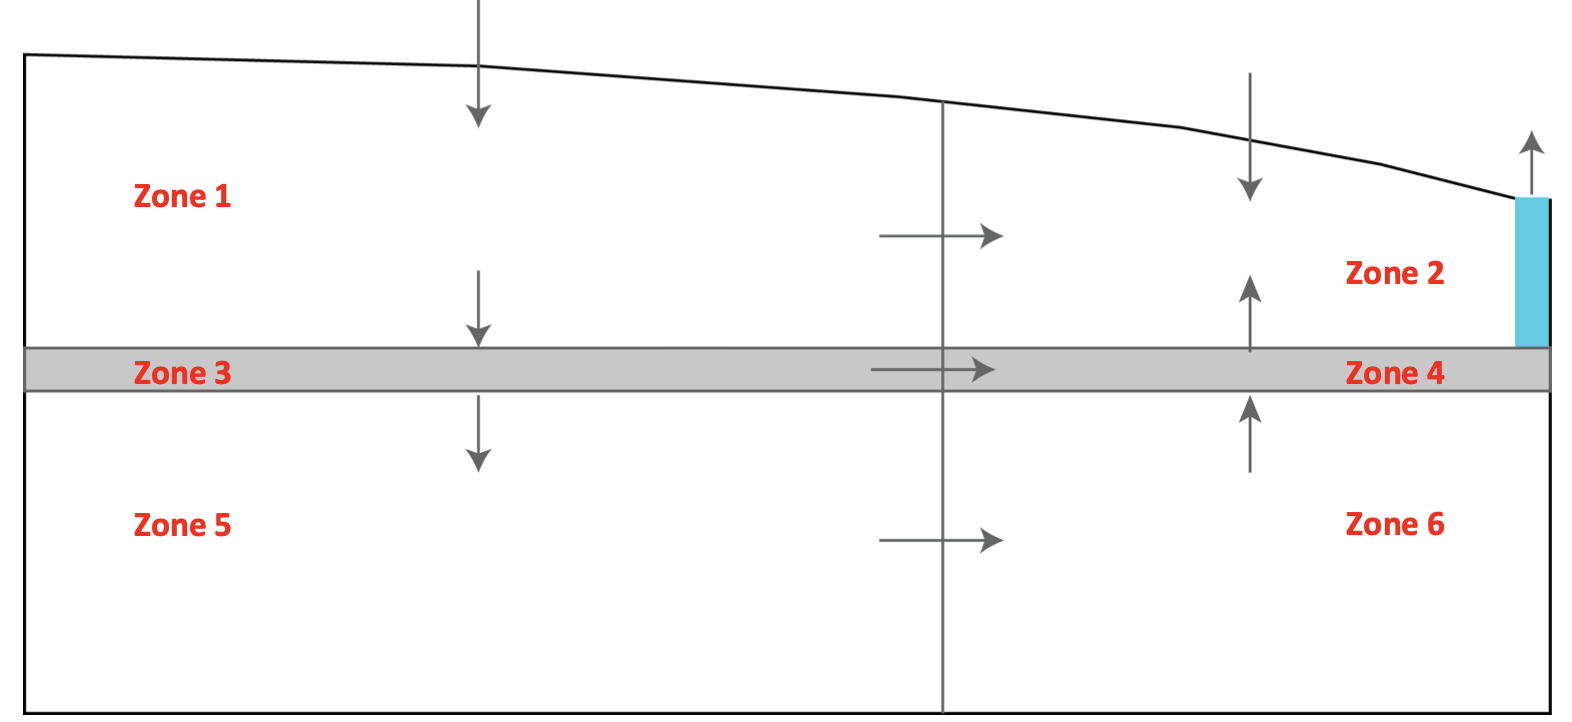

In [ ]:
r = m.rch.recharge[0][0]
r

In [ ]:
# these are just recharge multiplied by area
Zone1_in = r*21*13*500*500
Zone2_in = r*21*6*500*500

In [ ]:
# we already calculated the lateral exchanges Zone 1->2, 3->4, and 5->6 in the table above
table.Q

#### use these known amounts to fill in the diagram

In [ ]:
Zone_1_3 = Zone1_in-table.loc[0].Q
Zone_1_3

In [ ]:
Zone_3_5 = Zone_1_3-table.loc[1].Q
Zone_3_5

In [ ]:
Zone_6_4 = table.loc[2].Q
Zone_6_4

In [ ]:
Zone_4_2 = Zone_6_4 + table.loc[1].Q
Zone_4_2

In [ ]:
Into_river = Zone2_in + Zone_4_2 + table.loc[0].Q
Into_river

### exercise 8: figure out width of source area supplying R into layer 3

In [ ]:
# R into layer 3 is Zone_3_5
Zone_3_5

In [ ]:
#width x length_of_model * R = Zone_3_5
# width x 10,500 x 0.005 = Zone_3_5
width = Zone_3_5/(10500*.005)
width

# Part B: River Package

In [ ]:
if os.path.exists('./ps2b'):
    shutil.rmtree('./ps2b')
shutil.copytree('./ps2a/', './ps2b', dirs_exist_ok=True)

In [ ]:
# read in the model
sim = flopy.mf6.MFSimulation.load(sim_ws = './ps2b/', exe_name=mfexe)
m = sim.get_model()
m.remove_package(m.chd)

In [ ]:
# set the cells for which rivers will exist
rivcells = [(0,i,19) for i in range(m.dis.nrow.array)]
rivcells

In [ ]:
20*500*10

In [ ]:
# now make the stress period data for the river
riv_spd = pd.DataFrame(data={'cellid':rivcells,'stage':320, 'cond':20*500*10, 'rbot':317})

In [ ]:
riv_spd

In [ ]:
riv = flopy.mf6.ModflowGwfriv(m, save_flows=True, stress_period_data=riv_spd.to_records(index=None))

In [ ]:
sim.write_simulation()
sim.run_simulation()

In [ ]:
m2bhead = m.output.head().get_data()

In [ ]:
fig, ax = plt.subplots(3,2)
for i in range(m1head.shape[0]):
    d=ax[i,0].imshow(m2ahead[i])
    plt.colorbar(d)
    d=ax[i,1].imshow(m2bhead[i])
    plt.colorbar(d)
ax[0,0].set_title('PS2A')
ax[0,1].set_title('PS2B')
plt.tight_layout()

In [ ]:
m2b_bud = m.output.list().get_dataframes()[0]

In [ ]:
m2a1_bud

In [ ]:
m2b_bud

### excercise 9: 
### identify all the inflow and outflow terms for cell 1,1,20 (remember - use zero-based indices so 0,0,19). Compare the result to the flux to the River. close?

In [ ]:
# Qriv = (Qrch + Qleft + Qbot)

In [ ]:
k=50

In [ ]:
Q_rch = 500 * 500 * 0.005 #(dx x dy x R)
Q_rch

### flow from the left cell

In [ ]:
k=50
delh_left = m2bhead[0,0,19]-m2bhead[0,0,18]
b = np.mean((m2bhead[0,0,19],m2bhead[0,0,18]))-220

Q_left = -k * b * 500  * delh_left / 500
Q_left

### flow from the "south" cell

In [ ]:
k=50
delh_south = m2bhead[0,0,19]-m2bhead[0,1,19]
b = np.mean((m2bhead[0,0,19],m2bhead[0,1,19]))-220

Q_south = -k * b * 500  * delh_south / 500
Q_south

### Flow from the bottom cell:  
### tricky here, but best to calculate the half-cell conductances. Why? Because need to basically account for partial length when calculating an "average" K

In [ ]:
delh_bot = m2bhead[0,0,19]-m2bhead[1,0,19]

C1 = 10 * 500 * 500 / ((m.dis.top.array[0,19]-m.dis.botm.array[0,0,19])/2)
C2 = 0.01 * 500 * 500 / 10
Q_bot = -C1*C2/(C1+C2) * delh_bot 
Q_bot

In [ ]:
Q_riv = 525000 / 21
Q_riv

In [ ]:
Q_bot + Q_rch + Q_left + Q_south

# Part C: Drain and General Head Boundaries

In [ ]:
if os.path.exists('./ps2c/'):
    shutil.rmtree('./ps2c')
shutil.copytree('./ps2b/', './ps2c', dirs_exist_ok=True)

In [ ]:
# read in the model
sim = flopy.mf6.MFSimulation.load(sim_ws = './ps2c/', exe_name=mfexe)
m = sim.get_model()

### add the drains

In [ ]:
drain_cells = [(0,14,i) for i in range(9,20)]
drn_spd = pd.DataFrame(data={'celld':drain_cells, 'elev':322.5, 'cond':1e5})

In [ ]:
drn = flopy.mf6.ModflowGwfdrn(m, print_flows=True, stress_period_data=drn_spd.to_records(index=None))

In [ ]:
sim.write_simulation()
sim.run_simulation()

In [ ]:
m2chead = m.output.head().get_data()
fig, ax = plt.subplots(3,2)
for i in range(m1head.shape[0]):
    d=ax[i,0].imshow(m2bhead[i])
    plt.colorbar(d)
    d=ax[i,1].imshow(m2chead[i])
    plt.colorbar(d)


### Exercise 10: check out drain discharge differences between 1,15,18 and 1,15,19

In [ ]:
lst = open('./ps2c/ps2.lst', 'r').readlines()
strtline = [lst.index(i) for i in lst if 'DRN PACKAGE (DRN_0) FLOW RATES ' in i][0]

In [ ]:
[print(i.strip()) for i in lst[strtline:strtline+16]];

In [ ]:
# heads go below the drain so no flow into the drain at col. 18
m2chead[0,14,:]-322.5

In [ ]:
# we are going to need this a little later
m2c_bud = m.output.list().get_dataframes()[0]

### Exercise 11: copy to PS2C1 and replace DRN with GHB using the same information

In [ ]:
shutil.copytree('./ps2c/', './ps2c1', dirs_exist_ok=True)

In [ ]:
# read in the model
sim = flopy.mf6.MFSimulation.load(sim_ws = './ps2c1/', exe_name=mfexe)
sim.set_sim_path('ps2c1')
m = sim.get_model()
m.remove_package(m.drn)

In [ ]:
m.get_package_list()

In [ ]:
ghb = flopy.mf6.ModflowGwfghb(m, stress_period_data=drn_spd.to_records(index=None), print_flows=True)

In [ ]:
sim.write_simulation()
sim.run_simulation()

In [ ]:
m2c1head = m.output.head().get_data()
fig, ax = plt.subplots(3,2)
for i in range(m1head.shape[0]):
    d=ax[i,0].imshow(m2chead[i])
    plt.colorbar(d)
    d=ax[i,1].imshow(m2c1head[i])
    plt.colorbar(d)
ax[0,0].set_title('PS2C')
ax[0,1].set_title('PS2C1')
plt.tight_layout()

In [ ]:
lst = open('./ps2c1/ps2.lst', 'r').readlines()
strtline = [lst.index(i) for i in lst if 'GHB PACKAGE (GHB_0) FLOW RATES ' in i][0]

### So how does GHB flow rate change relative to the DRN version?

In [ ]:
[print(i.strip()) for i in lst[strtline:strtline+16]];

In [ ]:
lst = open('./ps2c/ps2.lst', 'r').readlines()
strtline = [lst.index(i) for i in lst if 'DRN PACKAGE (DRN_0) FLOW RATES ' in i][0]
[print(i.strip()) for i in lst[strtline:strtline+16]];

# Part D: Well Package

In [ ]:
if os.path.exists('./ps2d/'):
    shutil.rmtree('./ps2d')
shutil.copytree('./ps2c/', './ps2d', dirs_exist_ok=True)

In [ ]:
# read in the model
sim = flopy.mf6.MFSimulation.load(sim_ws = './ps2d/', exe_name=mfexe)
m = sim.get_model()

In [ ]:
wel = flopy.mf6.ModflowGwfwel(m, stress_period_data=[[(0,10,9), -75000]])

In [ ]:
sim.write_simulation()
sim.run_simulation()

In [ ]:
m2dhead = m.output.head().get_data()
fig, ax = plt.subplots(3,2)
for i in range(m1head.shape[0]):
    d=ax[i,0].imshow(m2chead[i])
    plt.colorbar(d)
    d=ax[i,1].imshow(m2dhead[i])
    plt.colorbar(d)
ax[0,0].set_title('PS2C')
ax[0,1].set_title('PS2D')
plt.tight_layout()

In [ ]:
m2d_bud = m.output.list().get_dataframes()[0]

In [ ]:
m2d_bud

In [ ]:
m2c_bud

In [ ]:
table_c_to_d = pd.DataFrame(data = {'package':['RIV','DRN','WEL'],
                                   'PS2D':[m2d_bud['RIV_OUT'].values[0],
                                          m2d_bud['DRN_OUT'].values[0],
                                          m2d_bud['WEL_OUT'].values[0]],
                                   'PS2C':[m2c_bud['RIV_OUT'].values[0],
                                          m2c_bud['DRN_OUT'].values[0],
                                          0]})
table_c_to_d['PS2D-PS2C'] = table_c_to_d.PS2D-table_c_to_d.PS2C

In [ ]:
table_c_to_d

In [ ]:
table_c_to_d['PS2D-PS2C'].sum()

# PART E: Transient Flow

In [ ]:
if os.path.exists('./ps2e/'):
    shutil.rmtree('./ps2e')
shutil.copytree('./ps2d/', './ps2e', dirs_exist_ok=True)

In [ ]:
# read in the model
sim = flopy.mf6.MFSimulation.load(sim_ws = './ps2e/', exe_name=mfexe)
m = sim.get_model()

In [ ]:
sim.tdis.nper=3
simpd = pd.DataFrame(data={'perlen':[300000,36500,300000],
                          'nstp':[1,10,1],
                          'tsmult':[1,1.5,1]})
sim.tdis.perioddata = simpd.to_records(index=None)

In [ ]:
sto = flopy.mf6.ModflowGwfsto(m, sy=0.1, ss=0.0001, iconvert=1, steady_state={0:True,1:False,2:True},
                             transient={0:False,1:True,2:False})

In [ ]:
sim.tdis.perioddata

### add the second well with the proper timing

In [ ]:
m.remove_package(m.wel)

In [ ]:
wel_spd = {0:[[(0,10,9), -75000]],
           1:[[(0,10,9), -75000],[(2,12,4), -100000]],
           2:[[(0,10,9), -75000],[(2,12,4), -100000]]}

In [ ]:
wel = flopy.mf6.ModflowGwfwel(m, stress_period_data=wel_spd)

In [ ]:
# m.oc.printrecord

In [ ]:
saverecord = pd.DataFrame(data={'rtype':['head','budget'], 
                                'ocsetting':['all','all'],
                                'ocsetting_data':[None, None]})

In [ ]:
# m.oc.saverecord = {i:saverecord.to_records(index=None) for i in range(3)}

In [ ]:
sim.write_simulation()
sim.run_simulation()

In [ ]:
times = m.output.head().get_times()

In [ ]:
times

In [ ]:
m2ehead = np.array([m.output.head().get_data(totim=i) for i in times])
m2ehead.shape

In [ ]:
for t in range(len(times)):
    fig, ax = plt.subplots(1,3, figsize=(8,4))
    for i in range(3):
        d=ax[i].imshow(m2ehead[t,i,:,:])
        plt.colorbar(d, shrink=.5)
        ax[i].set_title(f'head layer {i}')
    plt.suptitle(f'PS2E head at time={times[t]:.0f}')
    plt.tight_layout()

### Exercise 13: Look at the budgets and see how storage interacts with the river and drain

In [ ]:
m2e_budfile = fu.Mf6ListBudget('./ps2e/ps2.lst')

In [ ]:
m2e_bud_inc, m2e_bud_cumul = m2e_budfile.get_budget()

In [ ]:
m2e_bud_incdf = pd.DataFrame.from_records(m2e_bud_inc)
m2e_bud_incdf

In [ ]:
m2e_bud_incdf[['STO-SS_IN','STO-SY_IN','DRN_OUT','RIV_OUT']].plot()

### Excercise 14: Change the timing of the steady-state stress periods

In [ ]:
if os.path.exists('./ps2e_changed/'):
    shutil.rmtree('./ps2e_changed')
shutil.copytree('./ps2e/', './ps2e_changed', dirs_exist_ok=True)

In [ ]:
# read in the model
sim = flopy.mf6.MFSimulation.load(sim_ws = './ps2e_changed/', exe_name=mfexe)
m = sim.get_model()

In [ ]:
sim.tdis.nper=3
simpd = pd.DataFrame(data={'perlen':[1,36500,1],
                          'nstp':[1,10,1],
                          'tsmult':[1,1.5,1]})
sim.tdis.perioddata = simpd.to_records(index=None)
sim.tdis.perioddata

In [ ]:
sim.write_simulation()
sim.run_simulation()
m2e_changed_budfile = fu.Mf6ListBudget('./ps2e_changed/ps2.lst')
m2e_changed_bud_inc, m2e_changed_bud_cumul = m2e_changed_budfile.get_budget()

In [ ]:
m2e_changedbud_incdf = pd.DataFrame.from_records(m2e_changed_bud_inc)
m2e_changedbud_incdf

In [ ]:
# compare with the old longer times
m2e_bud_incdf